# Backtesting & Counterfactual Analysis.

This is the final proof point before a "Go/No-Go" decision. We will take historical loans that Prosper actually funded and simulate: "If we had priced these loans using our new AI Engine instead of the old human/manual process, what would have happened?"

We are looking for three wins:

1. Higher Yield: Did we find opportunities to charge more for sticky customers?

2. Lower Risk: Did we reject loans that later defaulted?

3. Competitive Wins: Did we offer lower rates to Prime borrowers who might have otherwise left?

In [1]:
import sys

sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.pricing_engine import LoanPricingEngine
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

# ---------------------------------------------------------
# 1. SETUP ENGINE
# ---------------------------------------------------------
# Load the full engine with the Policy Layer active
engine = LoanPricingEngine(
    risk_model_path="../models/risk_model_xgb.pkl",
    elasticity_model_path="../models/elasticity_model_logit.pkl",
    cost_of_funds=0.04,  # 4% Baseline CoF
)

print("✅ Pricing Engine Loaded.")

✅ Pricing Engine Loaded.


In [ ]:
X_test = pd.read_csv("../data/processed/prosper_X_test.csv")
y_test = pd.read_csv("../data/processed/prosper_y_test.csv")

# Combine features and target into one dataframe for simulation
backtest_df = X_test.copy()

In [3]:
target_col = y_test.columns[0]
backtest_df["Actual_Default"] = y_test[target_col]

In [4]:
if "BorrowerRate" not in backtest_df.columns:
    print(
        "⚠️ Warning: 'BorrowerRate' not found in X_test. Pricing Delta analysis will be skipped."
    )
    backtest_df["Actual_Rate"] = 0.15  # Placeholder
else:
    backtest_df["Actual_Rate"] = backtest_df["BorrowerRate"]

print(f"✅ Loaded Test Set: {len(backtest_df)} loans.")

⚠️ Warning: 'BorrowerRate' not found in X_test. Pricing Delta analysis will be skipped.
✅ Loaded Test Set: 283950 loans.


In [5]:
results = []
print("⏳ Running Backtest Simulation...")

# Simulation Loop
# Using tqdm for progress bar
simulation_subset = backtest_df

for idx, row in tqdm(
    simulation_subset.iterrows(),
    total=simulation_subset.shape[0],
    desc="Processing Loans",
):

    # 1. MAP FEATURES TO ENGINE INPUT
    # Ensure these keys match what your Engine expects (Brain 1 & Brain 2)
    applicant = {
        "risk_score_norm": row.get("risk_score_norm", 0.5),
        "annual_inc": row.get("annual_inc", 50000),
        "dti": row.get("dti", 0.25),
        "LoanOriginalAmount": row.get("LoanOriginalAmount", 15000),
        "revol_util": row.get("revol_util", 30),
        "inq_last_6mths": row.get("inq_last_6mths", 0),
        "total_acc": row.get("total_acc", 15),
        # Defaults for columns that might have been dropped during feature selection
        "term_years": 3,
        "emp_length": 5,
        "home_ownership_RENT": row.get("home_ownership_RENT", 0),
        "purpose_debt_consolidation": 1,
    }

    # 2. ASK THE ENGINE
    decision = engine.get_optimal_rate(applicant)

    # 3. RECORD RESULTS
    results.append(
        {
            "LoanID": idx,
            "Risk_Segment": decision["risk_segment"],
            "Actual_Rate": row.get("Actual_Rate", 0),
            "AI_Rate": decision["optimal_rate"],
            "AI_Decision": decision["decision"],
            "AI_PD": decision["prob_default"],
            "Actual_Outcome": "Default" if row["Actual_Default"] == 1 else "Paid",
            "AI_Exp_Profit": decision["max_profit"],
        }
    )

results_df = pd.DataFrame(results)
print("\n✅ Simulation Complete.")

⏳ Running Backtest Simulation...


Processing Loans: 100%|██████████| 283950/283950 [4:02:58<00:00, 19.48it/s]   



✅ Simulation Complete.


Did the AI reject the people who actually defaulted?

In [6]:
dodged_bullets = results_df[
    (results_df["Actual_Outcome"] == "Default")
    & (results_df["AI_Decision"] != "APPROVE")
]

# Loans that actually paid, but AI would have REJECTED (Opportunity Cost)
missed_opportunities = results_df[
    (results_df["Actual_Outcome"] == "Paid") & (results_df["AI_Decision"] != "APPROVE")
]

print("\n=== 🛡️ RISK SHIELD PERFORMANCE ===")
print(
    f"Total AI Rejections:      {len(results_df[results_df['AI_Decision'] != 'APPROVE'])}"
)
print(f"✅ Defaults Avoided:       {len(dodged_bullets)} (True Negatives)")
print(f"⚠️ Revenue Sacrificed:     {len(missed_opportunities)} (False Negatives)")

# Estimated Savings (assuming $15k avg loan * 60% loss severity)
savings = len(dodged_bullets) * 15000 * 0.6
print(f"💰 ESTIMATED LOSS PREVENTED: ${savings:,.0f}")


=== 🛡️ RISK SHIELD PERFORMANCE ===
Total AI Rejections:      17885
✅ Defaults Avoided:       8703 (True Negatives)
⚠️ Revenue Sacrificed:     9182 (False Negatives)
💰 ESTIMATED LOSS PREVENTED: $78,327,000


For the loans we BOTH approved, did we price them better?


=== 💰 ECONOMICS (Common Approvals) ===
Loans Repriced HIGHER (Yield Boost):   258389
Loans Repriced LOWER (Competitiveness): 411
Avg Rate Impact: 7.19%


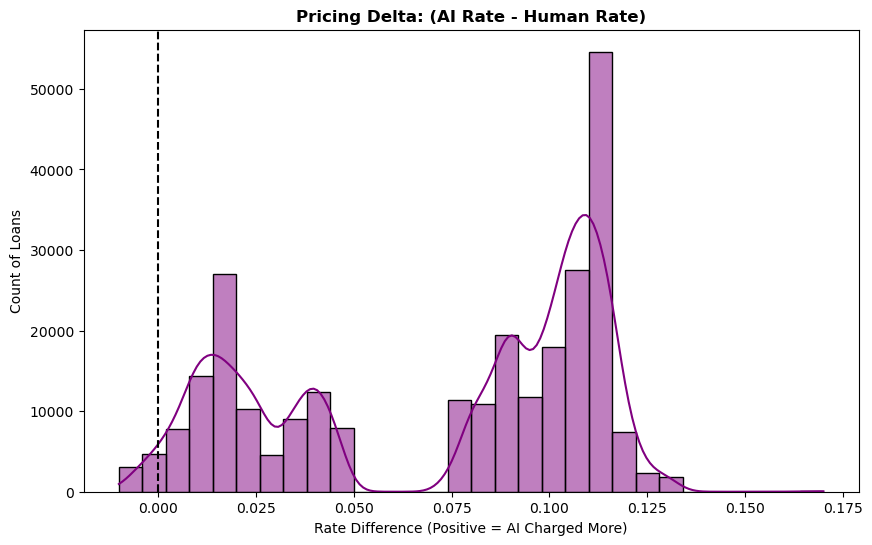

In [7]:
common = results_df[results_df["AI_Decision"] == "APPROVE"].copy()

if (
    len(common) > 0
    and "Actual_Rate" in common.columns
    and common["Actual_Rate"].mean() > 0
):
    common["Rate_Delta"] = common["AI_Rate"] - common["Actual_Rate"]

    plt.figure(figsize=(10, 6))
    sns.histplot(common["Rate_Delta"], bins=30, kde=True, color="purple")
    plt.axvline(0, color="black", linestyle="--")
    plt.title("Pricing Delta: (AI Rate - Human Rate)", fontweight="bold")
    plt.xlabel("Rate Difference (Positive = AI Charged More)")
    plt.ylabel("Count of Loans")

    # Calculate Stats
    upside_loans = len(common[common["Rate_Delta"] > 0.005])  # > 0.5% increase
    downside_loans = len(common[common["Rate_Delta"] < -0.005])  # > 0.5% decrease

    print("\n=== 💰 ECONOMICS (Common Approvals) ===")
    print(f"Loans Repriced HIGHER (Yield Boost):   {upside_loans}")
    print(f"Loans Repriced LOWER (Competitiveness): {downside_loans}")
    print(f"Avg Rate Impact: {common['Rate_Delta'].mean():.2%}")

    plt.show()
else:
    print("\nSkipping Pricing Chart: No 'BorrowerRate' or no overlapping approvals.")